### 0. 환경설정

c:\team_project\second_project_2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\team_project\second_project_2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\team_project\second_project_2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\team_project\second_project_2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\team_project\second_project_2\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) miss

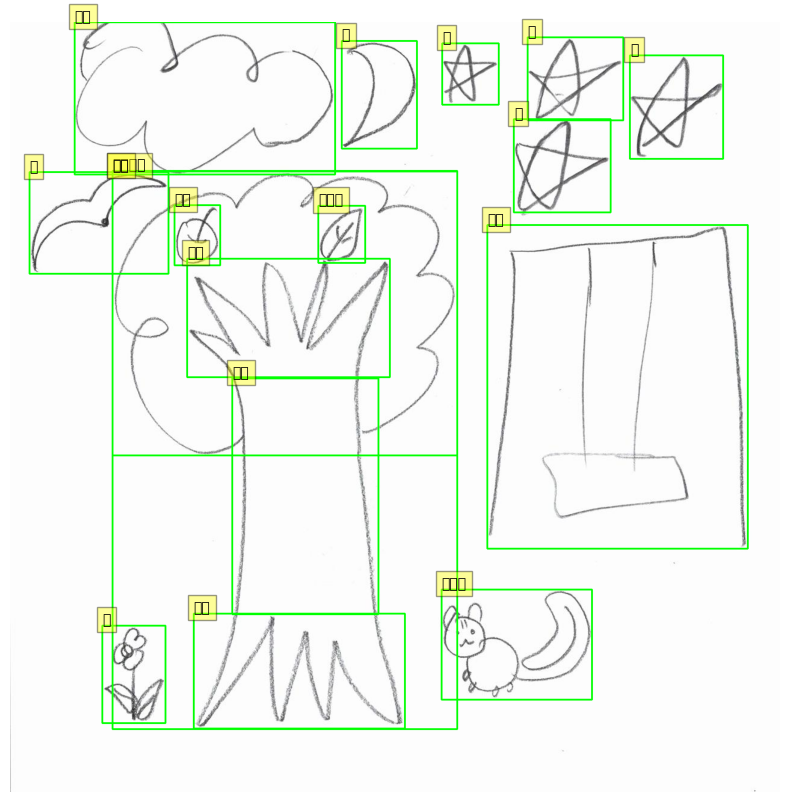

In [1]:
import numpy as np
import cv2, json
from pathlib import Path
import matplotlib.pyplot as plt

img_path  = Path(r"C:\team_project\second_project_2\266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축\01-1.정식개방데이터\Training\01.원천데이터\TS_나무\나무_7_남_00367.jpg")
json_path = Path(r"C:\team_project\second_project_2\266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축\01-1.정식개방데이터\Training\02.라벨링데이터\TL_나무\나무_7_남_00367.json")

# --- 이미지 robust 로드 (한글/긴 경로 이슈 회피) ---
data = np.fromfile(str(img_path), dtype=np.uint8)      # <- 파일을 바이트로 안전하게 읽기
img  = cv2.imdecode(data, cv2.IMREAD_COLOR)            # <- 디코딩
if img is None:
    raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {img_path}")

# --- JSON 로드 ---
with open(json_path, encoding="utf-8") as f:
    data = json.load(f)
bboxes = data["annotations"]["bbox"]

# --- 박스 그리기(OpenCV) ---
for box in bboxes:
    x, y, w, h = int(box["x"]), int(box["y"]), int(box["w"]), int(box["h"])
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)

# --- 노트북에서 표시(matplotlib, 한글 라벨은 plt.text로) ---
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.axis("off")
for box in bboxes:
    plt.text(int(box["x"]), int(box["y"])-3, box["label"], fontsize=10,
             bbox=dict(facecolor='yellow', alpha=0.4))
plt.show()


### 1. 전처리

전처리된 이미지 저장 완료: C:\team_project\second_project_2\preprocessed\나무_7_남_00242_prep.jpg


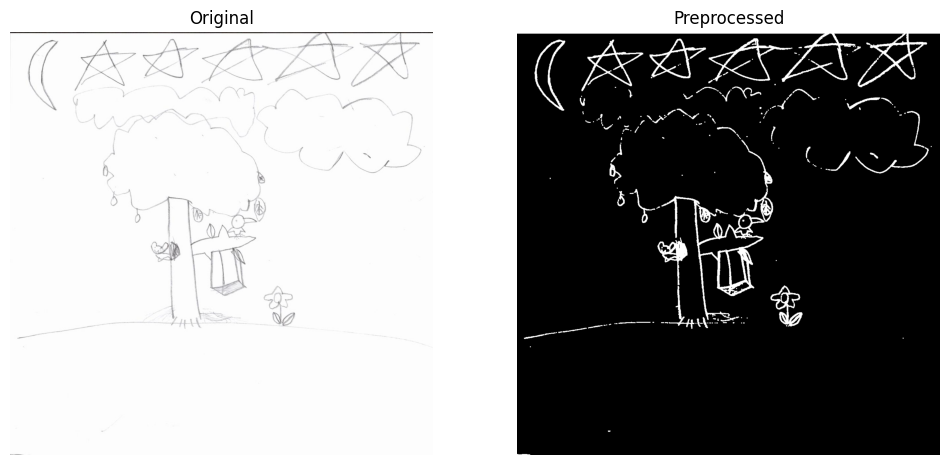

In [2]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# === 1) transform 함수 ===
def transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = cv2.bitwise_not(th)
    kernel = np.ones((3,3), np.uint8)
    thick = cv2.dilate(inv, kernel, iterations=1)
    return thick

# === 2) 원본 이미지 경로 (예시) ===
img_path = Path(r"C:\team_project\second_project_2\266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축\01-1.정식개방데이터\Training\01.원천데이터\TS_나무\나무_7_남_00242.jpg")

# === 3) 저장할 루트 (데이터 밖) ===
save_root = Path(r"C:\team_project\second_project_2\preprocessed")
save_root.mkdir(parents=True, exist_ok=True)

# === 4) 이미지 불러오기 (한글 경로 안전하게) ===
data = np.fromfile(str(img_path), dtype=np.uint8)
img = cv2.imdecode(data, cv2.IMREAD_COLOR)

# === 5) 전처리 적용 ===
processed = transform(img)

# === 6) 저장 ===
out_path = save_root / (img_path.stem + "_prep.jpg")
cv2.imencode(".jpg", processed)[1].tofile(str(out_path))

print(f"전처리된 이미지 저장 완료: {out_path}")

# === 7) 시각화 ===
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(processed, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.show()


In [20]:
import cv2
import numpy as np
from pathlib import Path
import time, os, sys

# ---- OpenCV 스레드/CL 제어(초기 호출 지연 완화에 도움) ----
try:
    cv2.setNumThreads(1)
except Exception:
    pass
try:
    cv2.ocl.setUseOpenCL(False)
except Exception:
    pass

# ---- 진행바(tqdm) 선택 ----
try:
    from tqdm import tqdm
except ImportError:
    tqdm = None

def pbar(iterable, total=None, desc=""):
    if tqdm is not None:
        return tqdm(iterable, total=total, desc=desc)
    # 간단 대체
    if total is None:
        iterable = list(iterable); total = len(iterable)
    def _gen():
        last_pct = -1
        for i, x in enumerate(iterable, 1):
            pct = int(i/total*100)
            if pct != last_pct and (pct % 5 == 0 or i == 1 or i == total):
                print(f"{desc} {pct}% ({i}/{total})")
                last_pct = pct
            yield x
    return _gen()

# ---- 전처리 함수(커널 캐시) ----
_KERNEL = np.ones((3,3), np.uint8)
def transform(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = cv2.bitwise_not(th)
    thick = cv2.dilate(inv, _KERNEL, iterations=1)
    return thick

# ---- 안전 저장 ----
def save_image_safely(img: np.ndarray, out_path: Path):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    ok, buf = cv2.imencode(".jpg", img)
    if not ok:
        raise RuntimeError(f"이미지 인코딩 실패: {out_path}")
    buf.tofile(str(out_path))  # 반환값 None 정상

# ---- 설정 ----
# 데이터셋 루트 (질문에서 주신 구조에 맞춰 "01-1.정식개방데이터"를 포함)
BASE = Path(r"C:\team_project\second_project_2\266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축\01-1.정식개방데이터")
OUT_ROOT = Path.cwd() / "preprocessed"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

SPLITS = [
    ("Training",   "01.원천데이터"),
    ("Validation", "01.원천데이터"),
]

# ---- 이미지 제너레이터: 리스트로 모으지 않고 즉시 yield ----
def iter_images(src_root: Path):
    exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")
    # 클래스 폴더(TS_*, VS_*) 하위 파일들 순회
    for cls_dir in src_root.iterdir():
        if not cls_dir.is_dir():
            continue
        for p in cls_dir.rglob("*"):
            # 너무 큰 폴더/불필요 폴더가 섞였을 수 있으니 파일만 필터
            if p.is_file() and p.suffix in exts:
                yield p

# ---- 파일 하나 처리(타이밍 로깅) ----
def process_one(img_path: Path, dst_dir: Path, warn_sec=10.0) -> bool:
    t0 = time.time()
    try:
        # 로드
        t_load0 = time.time()
        data = np.fromfile(str(img_path), dtype=np.uint8)
        img = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[로드 실패] {img_path}")
            return False
        t_load1 = time.time()

        # 전처리
        t_tf0 = time.time()
        proc = transform(img)
        t_tf1 = time.time()

        # 저장
        t_sv0 = time.time()
        out_path = dst_dir / (img_path.stem + "_prep.jpg")
        save_image_safely(proc, out_path)
        t_sv1 = time.time()

        # 오래 걸린 파일 경고
        t1 = time.time()
        elapsed = t1 - t0
        if elapsed > warn_sec:
            print(f"[경고: 지연 파일] {img_path} 총 {elapsed:.2f}s (load {t_load1-t_load0:.2f}s, "
                  f"transform {t_tf1-t_tf0:.2f}s, save {t_sv1-t_sv0:.2f}s)")
        return True

    except Exception as e:
        print(f"[에러] {img_path} -> {e}")
        return False

# ---- 스모크 테스트 + 전체 실행 ----
def preprocess_all(limit_first=20):
    total_files = 0
    total_ok = 0

    for split, folder in SPLITS:
        src_root = BASE / split / folder
        dst_split_root = OUT_ROOT / split
        dst_split_root.mkdir(parents=True, exist_ok=True)

        # 먼저 ‘앞의 N장’만 스모크 테스트
        print(f"\n=== {split} 스모크 테스트(앞의 {limit_first}장) ===")
        it = iter_images(src_root)
        ok_count = 0
        processed = 0
        for img_path in it:
            cls_name = img_path.parent.name
            dst_dir = dst_split_root / cls_name
            ok_count += int(process_one(img_path, dst_dir))
            processed += 1
            if processed >= limit_first:
                break

        print(f"[스모크] {split}: {ok_count}/{processed} 성공")
        if processed == 0:
            print(f"[경고] 이미지가 없습니다: {src_root}")
            continue

        # 스모크 통과 후 나머지 전체 진행
        print(f"=== {split} 전체 처리 시작 ===")
        # 스모크에서 이미 소비한 만큼 건너뛰며 다시 제너레이터 생성
        # (간단히 전체를 다시 순회하되, 앞의 limit_first개는 skip)
        skip = limit_first
        count = 0
        ok2 = 0
        # 총 개수를 알 수 없으므로 tqdm 없는 스트리밍 처리
        for img_path in iter_images(src_root):
            if skip > 0:
                skip -= 1
                continue
            cls_name = img_path.parent.name
            dst_dir = dst_split_root / cls_name
            ok2 += int(process_one(img_path, dst_dir))
            count += 1
            if count % 100 == 0:
                print(f"{split} 진행중... {count}장 처리 (성공 {ok2})")

        print(f"=== {split} 처리 완료: 스모크 {ok_count}/{processed} + 본처리 {ok2}/{count} ===")
        total_files += processed + count
        total_ok += ok_count + ok2

    print(f"\n전체 요약: {total_ok}/{total_files} 성공")
    print(f"저장 위치: {OUT_ROOT.resolve()}")

# 실행
preprocess_all(limit_first=20)



=== Training 스모크 테스트(앞의 20장) ===
[스모크] Training: 20/20 성공
=== Training 전체 처리 시작 ===
Training 진행중... 100장 처리 (성공 100)
Training 진행중... 200장 처리 (성공 200)
Training 진행중... 300장 처리 (성공 300)


KeyboardInterrupt: 

In [21]:
from pathlib import Path
import json
import cv2
import numpy as np

# ===== 설정 =====
PREP = Path(r"C:\team_project\second_project_2\preprocessed")
BASE_ORIG = Path(r"C:\team_project\second_project_2\266.AI 기반 아동 미술심리 진단을 위한 그림 데이터 구축\01-1.정식개방데이터")
SPLITS = ["Training", "Validation"]

# YOLO 클래스 모드
#  - "single": 모든 객체를 class 0(object)로 저장 (탐지만 할 때 권장)
#  - "all"   : JSON의 label명을 각각 클래스 id로 매핑
CLASSES_MODE = "single"

# (선택) 너무 작은 박스 필터링
ENABLE_MIN_FILTER = False
MIN_SIDE_PX  = 8
MIN_AREA_FR  = 5e-5  # 이미지 면적 대비 최소 비율

# ===== 유틸 =====
def parse_resolution(meta: dict, fallback_img: Path | None = None):
    W = H = None
    try:
        res = meta.get("img_resolution", "")
        if isinstance(res, str) and "x" in res:
            w_str, h_str = res.strip().split("x")
            W, H = int(w_str), int(h_str)
    except Exception:
        W = H = None

    if (W is None or H is None) and fallback_img is not None:
        data = np.fromfile(str(fallback_img), dtype=np.uint8)
        img  = cv2.imdecode(data, cv2.IMREAD_UNCHANGED)
        if img is not None and img.ndim >= 2:
            H, W = img.shape[:2]
    return W, H

def yolo_line_from_xywh(x, y, w, h, W, H, cls_id):
    xc = (x + w/2) / W
    yc = (y + h/2) / H
    wn = w / W
    hn = h / H
    # 클리핑
    xc = min(max(xc, 0.0), 1.0)
    yc = min(max(yc, 0.0), 1.0)
    wn = min(max(wn, 0.0), 1.0)
    hn = min(max(hn, 0.0), 1.0)
    return f"{cls_id} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n"

def json_dirs_for(split: str):
    lab_root = BASE_ORIG / split / "02.라벨링데이터"
    return sorted([p for p in lab_root.iterdir() if p.is_dir()])

def prep_img_dir(split: str, base_cls: str) -> Path:
    prefix = "TS_" if split == "Training" else "VS_"
    return PREP / split / f"{prefix}{base_cls}"

def label_out_dir(split: str, base_cls: str) -> Path:
    # 예: preprocessed/Training_label/나무/
    out = PREP / f"{split}_label" / base_cls
    out.mkdir(parents=True, exist_ok=True)
    return out

# ===== 메인 변환 =====
def convert_split(split: str):
    label_dirs = json_dirs_for(split)

    # 모든 JSON 수집
    json_files = []
    for d in label_dirs:
        json_files.extend(sorted(d.glob("*.json")))

    total = len(json_files)
    print(f"\n=== {split} 변환 시작 ({total} json) ===")

    # 다중 클래스 모드일 때만 사용
    cls2id, next_id = ({}, 0)

    done = 0
    saved = 0
    total_boxes = 0
    small_skips = 0
    json_err = 0

    for jp in json_files:
        try:
            with open(jp, encoding="utf-8") as f:
                data = json.load(f)
            meta = data.get("meta", {})
            ann  = data.get("annotations", {})
            bboxes = ann.get("bbox", [])

            # TL_나무 → 나무 / VL_남자사람 → 남자사람
            base_dir_name = jp.parent.name
            base_cls = base_dir_name.split("_", 1)[1] if "_" in base_dir_name else base_dir_name

            # 전처리 이미지 경로(참조용) 및 해상도
            img_stem = jp.stem + "_prep"
            img_path = prep_img_dir(split, base_cls) / f"{img_stem}.jpg"
            W, H = parse_resolution(meta, fallback_img=img_path)
            if W is None or H is None:
                done += 1
                if done % 50 == 0 or done == total:
                    print(f"{done}/{total}")
                continue

            # YOLO 라벨 라인 생성
            lines = []
            kept = 0
            for b in bboxes:
                x, y, w, h = int(b["x"]), int(b["y"]), int(b["w"]), int(b["h"])

                if ENABLE_MIN_FILTER:
                    if w < MIN_SIDE_PX or h < MIN_SIDE_PX or (w*h) < (W*H*MIN_AREA_FR):
                        small_skips += 1
                        continue

                if CLASSES_MODE == "single":
                    cid = 0
                else:
                    lbl = str(b.get("label", "unknown")).strip()
                    if lbl not in cls2id:
                        cls2id[lbl] = next_id
                        next_id += 1
                    cid = cls2id[lbl]

                lines.append(yolo_line_from_xywh(x, y, w, h, W, H, cid))
                kept += 1

            # 저장 경로: preprocessed/<split>_label/<나무|남자사람|여자사람|집>/<파일명_prep>.txt
            out_dir = label_out_dir(split, base_cls)
            out_txt = out_dir / f"{img_stem}.txt"
            with open(out_txt, "w", encoding="utf-8", newline="\n") as f:
                f.writelines(lines)

            saved += 1
            total_boxes += kept

        except Exception:
            json_err += 1

        done += 1
        # 진행률만
        if done % 50 == 0 or done == total:
            print(f"{done}/{total}")

    print(f"=== {split} 변환 완료 ===")
    print(f"저장된 txt: {saved}개 | 총 bbox: {total_boxes} | 소형 스킵: {small_skips} | JSON 오류: {json_err}")

    if CLASSES_MODE == "all" and cls2id:
        cls_file = PREP / f"{split}_label_classes.txt"
        with open(cls_file, "w", encoding="utf-8") as f:
            for name, idx in sorted(cls2id.items(), key=lambda x: x[1]):
                f.write(f"{idx}\t{name}\n")
        # 진행률만 요구하셔서 추가 출력은 생략합니다.

def main():
    for split in SPLITS:
        convert_split(split)

main()



=== Training 변환 시작 (44800 json) ===
50/44800
100/44800
150/44800


KeyboardInterrupt: 

In [3]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [11]:
# ============================================
# YOLOv3 from scratch (Detection only, NC=1)
#  - 데이터: 전처리 이미지 + 단일 클래스 YOLO txt
#  - 라벨 위치: preprocessed/{split}_label/<base_cls>/<stem>.txt
#  - 이미지:  preprocessed/{split}/(TS_|VS_)<base_cls>/<stem>.jpg
# ============================================
import math, time, random
from pathlib import Path
from typing import List, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms
import numpy as np, cv2

# ---------------- 설정 ----------------
PREP_ROOT = Path(r"C:\team_project\second_project_2\preprocessed")
TRAIN_IMG_ROOT = PREP_ROOT / "Training"     # TS_* 하위
VAL_IMG_ROOT   = PREP_ROOT / "Validation"   # VS_* 하위
TRAIN_LBL_ROOT = PREP_ROOT / "Training_label"
VAL_LBL_ROOT   = PREP_ROOT / "Validation_label"

IMGSZ   = 416
BATCH   = 16
EPOCHS  = 1
LR      = 1e-3
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
WORKERS = 4
SAVE_DIR= Path.cwd() / "runs_scratch"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# YOLOv3 기본 앵커 (px, 416 기준) - 3 스케일 × 3 앵커
ANCHORS = torch.tensor([[10,13],[16,30],[33,23],
                        [30,61],[62,45],[59,119],
                        [116,90],[156,198],[373,326]], dtype=torch.float32).view(3,3,2)
STRIDES = [8,16,32]
NC = 1           # 단일 클래스 탐지
NA = 3           # 스케일별 앵커 수
NO = 5 + NC      # (tx,ty,tw,th,obj) + C

# --------------- 유틸 ---------------
def letterbox(img, new_shape=416, color=(114,114,114)):
    h0, w0 = img.shape[:2]
    if isinstance(new_shape, int): new_shape = (new_shape, new_shape)
    r = min(new_shape[0]/h0, new_shape[1]/w0)
    nw, nh = int(round(w0*r)), int(round(h0*r))
    img = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_LINEAR)
    dw, dh = new_shape[1] - nw, new_shape[0] - nh
    dw /= 2; dh /= 2
    top, bottom = int(round(dh-0.1)), int(round(dh+0.1))
    left, right = int(round(dw-0.1)), int(round(dw+0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return img, r, (dw, dh)

def xywhn_to_xyxy(x, w, h, padw=0, padh=0):
    y = x.clone()
    y[:,0] = (x[:,0]-x[:,2]/2)*w + padw
    y[:,1] = (x[:,1]-x[:,3]/2)*h + padh
    y[:,2] = (x[:,0]+x[:,2]/2)*w + padw
    y[:,3] = (x[:,1]+x[:,3]/2)*h + padh
    return y

def bbox_iou_ciou(b1, b2, eps=1e-7):
    # 입력: xywh (px)
    b1_x1 = b1[...,0]-b1[...,2]/2; b1_y1 = b1[...,1]-b1[...,3]/2
    b1_x2 = b1[...,0]+b1[...,2]/2; b1_y2 = b1[...,1]+b1[...,3]/2
    b2_x1 = b2[...,0]-b2[...,2]/2; b2_y1 = b2[...,1]-b2[...,3]/2
    b2_x2 = b2[...,0]+b2[...,2]/2; b2_y2 = b2[...,1]+b2[...,3]/2

    inter = (torch.min(b1_x2,b2_x2)-torch.max(b1_x1,b2_x1)).clamp(0) * \
            (torch.min(b1_y2,b2_y2)-torch.max(b1_y1,b2_y1)).clamp(0)
    area1 = (b1_x2-b1_x1).clamp(0)*(b1_y2-b1_y1).clamp(0)
    area2 = (b2_x2-b2_x1).clamp(0)*(b2_y2-b2_y1).clamp(0)
    iou = inter / (area1+area2-inter+eps)

    cw = torch.max(b1_x2,b2_x2)-torch.min(b1_x1,b2_x1)
    ch = torch.max(b1_y2,b2_y2)-torch.min(b1_y1,b2_y1)
    c2 = cw**2 + ch**2 + eps

    rho2 = (b2[...,0]-b1[...,0])**2 + (b2[...,1]-b1[...,1])**2
    v = (4/math.pi**2) * torch.pow(torch.atan(b2[...,2]/(b2[...,3]+eps)) - torch.atan(b1[...,2]/(b1[...,3]+eps)),2)
    with torch.no_grad():
        alpha = v / (v - iou + 1 + eps)
    ciou = iou - rho2/c2 - alpha*v
    return ciou

def read_bgr(p: Path):
    data = np.fromfile(str(p), dtype=np.uint8)
    im = cv2.imdecode(data, cv2.IMREAD_COLOR)
    return im

In [6]:
# --------------- 모델 ---------------
import torch, torch.nn as nn, torch.nn.functional as F
from torchvision.ops import nms
from typing import List, Tuple

def conv_bn_lrelu(c_in,c_out,k,s,p):
    return nn.Sequential(nn.Conv2d(c_in,c_out,k,s,p,bias=False),
                         nn.BatchNorm2d(c_out),
                         nn.LeakyReLU(0.1, inplace=True))

class ResBlock(nn.Module):
    def __init__(self,c): 
        super().__init__()
        # Darknet-53 residual block
        self.cv1 = conv_bn_lrelu(c, c//2, 1,1,0)
        self.cv2 = conv_bn_lrelu(c//2, c, 3,1,1)
    def forward(self,x): return x + self.cv2(self.cv1(x))

class Darknet53(nn.Module):
    def __init__(self):
        super().__init__()
        c=32
        self.stem = conv_bn_lrelu(3,c,3,1,1)
        self.s1 = nn.Sequential(conv_bn_lrelu(c, c*2,3,2,1), ResBlock(c*2))
        self.s2 = nn.Sequential(conv_bn_lrelu(c*2,c*4,3,2,1), *[ResBlock(c*4) for _ in range(2)])
        self.s3 = nn.Sequential(conv_bn_lrelu(c*4,c*8,3,2,1), *[ResBlock(c*8) for _ in range(8)])
        self.s4 = nn.Sequential(conv_bn_lrelu(c*8,c*16,3,2,1),*[ResBlock(c*16) for _ in range(8)])
        self.s5 = nn.Sequential(conv_bn_lrelu(c*16,c*32,3,2,1),*[ResBlock(c*32) for _ in range(4)])
    def forward(self,x):
        x = self.stem(x)
        x = self.s1(x)
        c3 = self.s2(x)    # 52x52
        c4 = self.s3(c3)   # 26x26
        c5 = self.s4(c4)   # 13x13 (추가 stage는 채널 확장용)
        c5 = self.s5(c5)
        return c3, c4, c5

class YOLOHead(nn.Module):
    def __init__(self, c_in, c_out, na=3, no=NO):
        super().__init__()
        self.m = nn.Sequential(
            conv_bn_lrelu(c_in, c_out,1,1,0),
            conv_bn_lrelu(c_out, c_out*2,3,1,1),
            conv_bn_lrelu(c_out*2, c_out,1,1,0),
            conv_bn_lrelu(c_out, c_out*2,3,1,1),
            conv_bn_lrelu(c_out*2, c_out,1,1,0),
        )
        self.pred = nn.Conv2d(c_out, na*no, 1,1,0)
    def forward(self,x):
        x = self.m(x)
        return self.pred(x), x

class YOLOv3(nn.Module):
    def __init__(self, nc=NC, anchors=ANCHORS, strides=STRIDES):
        super().__init__()
        self.nc = nc; self.no = 5+nc; self.na = anchors.shape[1]
        self.anchors = anchors.clone(); self.strides = strides
        self.backbone = Darknet53()

        self.c5_reduce = conv_bn_lrelu(1024, 512, 1,1,0)
        self.h_big = YOLOHead(512, 256, na=self.na, no=self.no)

        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up1_conv = conv_bn_lrelu(256, 128, 1,1,0)
        self.c4_fuse = conv_bn_lrelu(512+128, 256, 1,1,0)
        self.h_mid = YOLOHead(256, 128, na=self.na, no=self.no)

        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")
        self.up2_conv = conv_bn_lrelu(128, 64, 1,1,0)
        self.c3_fuse = conv_bn_lrelu(256+64, 128, 1,1,0)
        self.h_small = YOLOHead(128, 64, na=self.na, no=self.no)

    def forward(self,x):
        c3,c4,c5 = self.backbone(x)
        p5 = self.c5_reduce(c5)
        out_big, r5 = self.h_big(p5)

        u1 = self.up1(r5)
        u1 = self.up1_conv(u1)
        p4 = self.c4_fuse(torch.cat([u1, c4], 1))
        out_mid, r4 = self.h_mid(p4)

        u2 = self.up2(r4)
        u2 = self.up2_conv(u2)
        p3 = self.c3_fuse(torch.cat([u2, c3], 1))
        out_small, _ = self.h_small(p3)

        return [out_small, out_mid, out_big]  # 52/26/13

In [7]:
# --------------- 손실/타깃 ---------------
class YoloLoss(nn.Module):
    def __init__(self, anchors=ANCHORS, strides=STRIDES, nc=NC):
        super().__init__()
        self.anchors = anchors; self.strides = strides; self.nc = nc
        self.bce = nn.BCEWithLogitsLoss(reduction='mean')

    def decode(self, p, li):
        na = self.anchors.shape[1]; no = 5+self.nc
        B, _, H, W = p.shape
        p = p.view(B, na, no, H, W).permute(0,1,3,4,2).contiguous()

        yv, xv = torch.meshgrid([torch.arange(H, device=p.device),
                                 torch.arange(W, device=p.device)], indexing='ij')
        grid = torch.stack((xv,yv),2).view(1,1,H,W,2).float()
        anchor = (self.anchors[li].to(p.device)/self.strides[li]).view(1,na,1,1,2)

        xy = (p[...,0:2].sigmoid()+grid)*self.strides[li]
        wh = (p[...,2:4].exp()*anchor*self.strides[li])
        obj = p[...,4]
        cls = p[...,5:]
        return p, xy, wh, obj, cls

    def build_targets(self, targets):
        # targets: (N,6) = (img_idx, cls(=0), xc, yc, w, h) normalized
        txy=[]; twh=[]; tcls=[]; tobj=[]; indices=[]
        if targets.numel()==0:
            for _ in range(3):
                txy.append(torch.zeros((0,2), device=targets.device))
                twh.append(torch.zeros((0,2), device=targets.device))
                tcls.append(torch.zeros((0,NC), device=targets.device))
                tobj.append(torch.zeros((0,), device=targets.device))
                indices.append((torch.zeros(0,dtype=torch.long,device=targets.device),
                                torch.zeros(0,dtype=torch.long,device=targets.device),
                                torch.zeros(0,dtype=torch.long,device=targets.device),
                                torch.zeros(0,dtype=torch.long,device=targets.device)))
            return txy,twh,tcls,tobj,indices

        # 정규화→픽셀
        t = targets.clone()
        t[:,2:] *= IMGSZ
        gwh = t[:,4:6]  # (w,h) px

        all_anchors = ANCHORS.view(-1,2).to(t.device)
        ratios = gwh[:,None,:]/(all_anchors[None,:,:]+1e-9)
        inv    = (all_anchors[None,:,:])/(gwh[:,None,:]+1e-9)
        r = torch.max(ratios, inv).max(2)[0]
        best_a = r.argmin(1)  # 0~8

        for li, stride in enumerate(STRIDES):
            na = ANCHORS.shape[1]
            m = (best_a//na == li)
            if m.sum()==0:
                txy.append(torch.zeros((0,2), device=t.device))
                twh.append(torch.zeros((0,2), device=t.device))
                tcls.append(torch.zeros((0,NC), device=t.device))
                tobj.append(torch.zeros((0,), device=t.device))
                indices.append((torch.zeros(0,dtype=torch.long,device=t.device),
                                torch.zeros(0,dtype=torch.long,device=t.device),
                                torch.zeros(0,dtype=torch.long,device=t.device),
                                torch.zeros(0,dtype=torch.long,device=t.device)))
                continue
            ts = t[m]; a = (best_a[m] % na)

            gx, gy = ts[:,2]/stride, ts[:,3]/stride
            gi, gj = gx.long(), gy.long()
            tx, ty = gx-gi, gy-gj
            tw = torch.log((ts[:,4]/(ANCHORS[li][a][:,0]+1e-9)))
            th = torch.log((ts[:,5]/(ANCHORS[li][a][:,1]+1e-9)))

            txy.append(torch.stack([tx,ty],1))
            twh.append(torch.stack([tw,th],1))
            onehot = torch.zeros((ts.size(0), NC), device=t.device); onehot[:,0]=1.0
            tcls.append(onehot)
            tobj.append(torch.ones(ts.size(0), device=t.device))
            indices.append((ts[:,0].long(), a.long(),
                            gj.clamp(0, (IMGSZ//stride)-1),
                            gi.clamp(0, (IMGSZ//stride)-1)))
        return txy,twh,tcls,tobj,indices

    def forward(self, preds, targets):
        lbox = torch.zeros(1, device=preds[0].device)
        lobj = torch.zeros(1, device=preds[0].device)
        lcls = torch.zeros(1, device=preds[0].device)

        txy,twh,tcls,tobj,indices = self.build_targets(targets)
        for li,p in enumerate(preds):
            p_raw, p_xy, p_wh, p_obj, p_cls = self.decode(p, li)
            b,a,gj,gi = indices[li]
            if b.numel():
                pred_xy = p_xy[b,a,gj,gi]
                pred_wh = p_wh[b,a,gj,gi]

                tgt_xy = (torch.stack([gi,gj],1).float()+txy[li]) * STRIDES[li]
                tgt_wh = torch.exp(twh[li]) * ANCHORS[li][a].to(p.device)

                lbox += (1.0 - bbox_iou_ciou(torch.cat([pred_xy,pred_wh],1),
                                             torch.cat([tgt_xy,tgt_wh],1))).mean()

                tobj_i = torch.zeros_like(p_obj); tobj_i[b,a,gj,gi] = 1.0
                lobj += self.bce(p_obj, tobj_i)

                if NC>1:  # 현재 NC=1이므로 pass
                    pc = p_cls[b,a,gj,gi]
                    lcls += self.bce(pc, tcls[li])
            else:
                tobj_i = torch.zeros_like(p_obj)
                lobj += self.bce(p_obj, tobj_i)

        return lbox + lobj + lcls, (lbox.item(), lobj.item(), lcls.item())

In [8]:
# --------------- 데이터셋 ---------------
def list_images(img_root: Path):
    files=[]
    for d in sorted(img_root.iterdir()):
        if d.is_dir():
            files+=sorted(d.glob("*.jpg"))
    return files

def infer_base_cls_from_imgpath(p: Path):
    # TS_나무 → 나무 / VS_남자사람 → 남자사람
    name = p.parent.name
    return name.split("_",1)[1] if "_" in name else name

class YoloTxtDataset(Dataset):
    def __init__(self, img_root: Path, lbl_root: Path, imgsz=416, augment=True):
        self.img_paths = list_images(img_root)
        self.lbl_root  = lbl_root
        self.imgsz     = imgsz
        self.augment   = augment

    def __len__(self): return len(self.img_paths)

    def _imread(self, p: Path):
        data = np.fromfile(str(p), dtype=np.uint8)
        im   = cv2.imdecode(data, cv2.IMREAD_COLOR)
        if im is None: raise FileNotFoundError(p)
        return im

    def _label_path_for(self, img_path: Path) -> Path:
        base_cls = infer_base_cls_from_imgpath(img_path)
        stem     = img_path.stem
        return self.lbl_root / base_cls / f"{stem}.txt"

    def _load_yolo_labels(self, txt_path: Path):
        if not txt_path.exists():
            return np.zeros((0,5), dtype=np.float32)
        lines = txt_path.read_text(encoding="utf-8").strip().splitlines()
        out=[]
        for ln in lines:
            sp = ln.split()
            if len(sp)!=5: continue
            c,xc,yc,w,h = map(float, sp)
            out.append([c,xc,yc,w,h])
        return np.array(out, dtype=np.float32)

    def __getitem__(self, i):
        ip = self.img_paths[i]
        img0 = self._imread(ip)
        h0,w0 = img0.shape[:2]

        lb, r, (dw,dh) = letterbox(img0, self.imgsz)
        h,w = lb.shape[:2]

        lbl_path = self._label_path_for(ip)
        yolo = self._load_yolo_labels(lbl_path)  # (N,5) norm
        if yolo.size>0:
            xyxy = xywhn_to_xyxy(torch.from_numpy(yolo[:,1:5]), w0, h0, 0, 0)
            xyxy[:,[0,2]] = xyxy[:,[0,2]]*r + dw
            xyxy[:,[1,3]] = xyxy[:,[1,3]]*r + dh
            cx = ((xyxy[:,0]+xyxy[:,2])/2)/w
            cy = ((xyxy[:,1]+xyxy[:,3])/2)/h
            ww = (xyxy[:,2]-xyxy[:,0])/w
            hh = (xyxy[:,3]-xyxy[:,1])/h
            labels = torch.zeros((xyxy.shape[0],6))
            labels[:,1] = 0.0
            labels[:,2] = cx; labels[:,3] = cy; labels[:,4] = ww; labels[:,5] = hh
        else:
            labels = torch.zeros((0,6))

        # 간단 증강(좌우 반전)
        if self.augment and random.random()<0.5:
            lb = cv2.flip(lb, 1)
            if labels.size(0):
                labels[:,2] = 1.0 - labels[:,2]

        rgb = cv2.cvtColor(lb, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        rgb = torch.from_numpy(rgb).permute(2,0,1).contiguous()
        labels[:,0] = i  # image index
        return rgb, labels, ip.name

def collate_fn(batch):
    imgs, labels, names = zip(*batch)
    imgs   = torch.stack(imgs, 0)
    labels = torch.cat(labels, 0)
    return imgs, labels, names

In [9]:
# --------------- 학습/평가 루프 ---------------
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    TL=TB=TO=TC=0.0; n=0
    for imgs, targets, _ in loader:
        imgs    = imgs.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE)
        preds = model(imgs)
        loss,(lb,lo,lc) = criterion(preds, targets)
        bsz = imgs.size(0)
        TL += loss.item()*bsz; TB += lb*bsz; TO += lo*bsz; TC += lc*bsz
        n += bsz
    return TL/n, TB/n, TO/n, TC/n

def train():
    print("데이터 로딩 중 ...")
    train_set = YoloTxtDataset(TRAIN_IMG_ROOT, TRAIN_LBL_ROOT, imgsz=IMGSZ, augment=True)
    val_set   = YoloTxtDataset(VAL_IMG_ROOT,   VAL_LBL_ROOT,   imgsz=IMGSZ, augment=False)
    train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True, num_workers=WORKERS, pin_memory=True, collate_fn=collate_fn)
    val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False,num_workers=WORKERS, pin_memory=True, collate_fn=collate_fn)

    print(f"학습 이미지: {len(train_set)} | 검증 이미지: {len(val_set)}")

    model = YOLOv3(nc=NC, anchors=ANCHORS, strides=STRIDES).to(DEVICE)
    criterion = YoloLoss(anchors=ANCHORS, strides=STRIDES, nc=NC).to(DEVICE)
    optim = torch.optim.Adam(model.parameters(), lr=LR)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS, eta_min=LR*0.1)

    best = 1e9
    best_path = SAVE_DIR / "yolov3_scratch_best.pt"

    for ep in range(1, EPOCHS+1):
        model.train()
        ep_loss = 0.0
        t0 = time.time()
        for imgs, targets, _ in train_loader:
            imgs    = imgs.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE)
            optim.zero_grad()
            preds = model(imgs)
            loss,_ = criterion(preds, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optim.step()
            ep_loss += loss.item()*imgs.size(0)

        sched.step()
        tr = ep_loss/len(train_set)
        va, lb, lo, lc = evaluate(model, val_loader, criterion)
        dt = time.time()-t0
        print(f"[{ep:03d}/{EPOCHS}] train {tr:.4f} | val {va:.4f} (box {lb:.3f}, obj {lo:.3f}) | {dt:.1f}s")

        if va < best:
            best = va
            torch.save({"model": model.state_dict(),
                        "anchors": ANCHORS,
                        "strides": STRIDES,
                        "nc": NC}, best_path)
            print(f"  ↳ 베스트 저장: {best_path}")

    last_path = SAVE_DIR / "yolov3_scratch_last.pt"
    torch.save({"model": model.state_dict(),
                "anchors": ANCHORS,
                "strides": STRIDES,
                "nc": NC}, last_path)
    print(f"최종 저장: {last_path}")
    return best_path

In [10]:
# --------------- 추론 + 크롭 반환(선택) ---------------
@torch.no_grad()
def infer_and_crop(weights_path: Path, image_path: Path, conf_thres=0.25, iou_thres=0.45, imgsz=IMGSZ):
    ckpt = torch.load(weights_path, map_location=DEVICE)
    model = YOLOv3(nc=ckpt.get("nc",1), anchors=ckpt["anchors"], strides=ckpt["strides"]).to(DEVICE)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    img0 = read_bgr(image_path)
    img, r, (dw,dh) = letterbox(img0, imgsz)
    h,w = img.shape[:2]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    tensor = torch.from_numpy(rgb).permute(2,0,1).unsqueeze(0).to(DEVICE)

    outs = model(tensor)
    dets=[]
    for li,p in enumerate(outs):
        B,_,H,W = p.shape; na = ANCHORS.shape[1]
        p = p.view(B,na,NO,H,W).permute(0,1,3,4,2)[0]

        yv,xv = torch.meshgrid([torch.arange(H, device=DEVICE), torch.arange(W, device=DEVICE)], indexing='ij')
        grid  = torch.stack((xv,yv),2).view(1,H,W,2).float()
        anchor= (ANCHORS[li].to(DEVICE)/STRIDES[li]).view(na,1,1,2)

        xy = (p[...,0:2].sigmoid()+grid)*STRIDES[li]
        wh = (p[...,2:4].exp()*anchor*STRIDES[li])
        obj= p[...,4].sigmoid()
        score = obj  # NC=1

        m = score>conf_thres
        xy,wh,score = xy[m], wh[m], score[m]
        if xy.numel():
            boxes = torch.zeros((xy.size(0),4), device=DEVICE)
            boxes[:,0]=xy[:,0]-wh[:,0]/2; boxes[:,1]=xy[:,1]-wh[:,1]/2
            boxes[:,2]=xy[:,0]+wh[:,0]/2; boxes[:,3]=xy[:,1]+wh[:,1]/2
            idx = nms(boxes, score, iou_thres)
            dets.append(torch.cat([boxes[idx], score[idx].unsqueeze(1)],1))
    if len(dets):
        dets=torch.cat(dets,0)
        dets[:,[0,2]]-=dw; dets[:,[1,3]]-=dh; dets[:,:4]/=r
        dets=dets.cpu().numpy()
    else:
        dets=np.zeros((0,5),dtype=np.float32)

    crops=[]
    H0,W0=img0.shape[:2]
    for x1,y1,x2,y2,sc in dets:
        x1=int(max(0,min(W0-1,x1))); y1=int(max(0,min(H0-1,y1)))
        x2=int(max(0,min(W0-1,x2))); y2=int(max(0,min(H0-1,y2)))
        if x2<=x1 or y2<=y1: continue
        crop = img0[y1:y2, x1:x2].copy()
        crops.append((crop,(x1,y1,x2,y2),float(sc)))
        cv2.rectangle(img0,(x1,y1),(x2,y2),(0,255,0),2)
    return img0, crops

In [1]:
# ==== 드라이런: 데이터로더가 첫 배치를 뽑는지 10초 안에 점검 ====
from pathlib import Path
import time
import torch
from torch.utils.data import DataLoader

# 위에서 정의한 YoloTxtDataset, collate_fn, 경로들(PREP_ROOT 등)을 그대로 사용한다고 가정
IMGSZ = 416
BATCH = 8     # 작게
WORKERS = 0   # Jupyter/Windows hang 방지
PIN = False
PERSIST = False

train_set = YoloTxtDataset(TRAIN_IMG_ROOT, TRAIN_LBL_ROOT, imgsz=IMGSZ, augment=True)
print("train_set 길이:", len(train_set))

t0 = time.time()
# 첫 샘플 직접 로드 테스트
_ = train_set[0]
print("개별 샘플 OK, 소요:", round(time.time()-t0, 2), "s")

# DataLoader 드라이런
loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,
                    num_workers=WORKERS, pin_memory=PIN,
                    persistent_workers=PERSIST, collate_fn=collate_fn)

t1 = time.time()
it = iter(loader)
imgs, targets, names = next(it)  # 첫 배치 뽑기
print("첫 배치 뽑기 OK, 소요:", round(time.time()-t1, 2), "s")
print("배치 모양:", imgs.shape, "라벨 수:", targets.shape)


NameError: name 'YoloTxtDataset' is not defined

In [ ]:
# --------------- 실행 ---------------
best_path = train()

데이터 로딩 중 ...
학습 이미지: 44800 | 검증 이미지: 5600


In [ ]:
사전